In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
import os
import numpy as np
import skimage.io as io
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [4]:
import nibabel as nib
from PIL import Image
import random

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize

In [5]:
BASE_DIR = "./Data/3d_brain_tumor_segmentation/MICCAI_BraTS2020_TrainingData"

In [6]:
label_paths = glob.glob(os.path.join(BASE_DIR,"**","*seg.nii"))
flair_paths = glob.glob(os.path.join(BASE_DIR,"**","*flair.nii"))
t1_paths = glob.glob(os.path.join(BASE_DIR,"**","*t1.nii"))
t1ce_paths = glob.glob(os.path.join(BASE_DIR,"**","*t1ce.nii"))
t2_paths = glob.glob(os.path.join(BASE_DIR,"**","*t2.nii"))

In [7]:
# Let's create a dictionary of dictionary to order the data
full_data = {i:{'label':label,
   'flair':flair,
   't1':t1,
   't1ce':t1ce,
   't2':t2} for i, (label,flair,t1,t1ce,t2) \
 in enumerate(zip(label_paths, 
                  flair_paths, 
                  t1_paths, 
                  t1ce_paths, 
                  t2_paths))}

In [6]:
# Let us now visualize any random image across the three dimensions and different channels/modalities

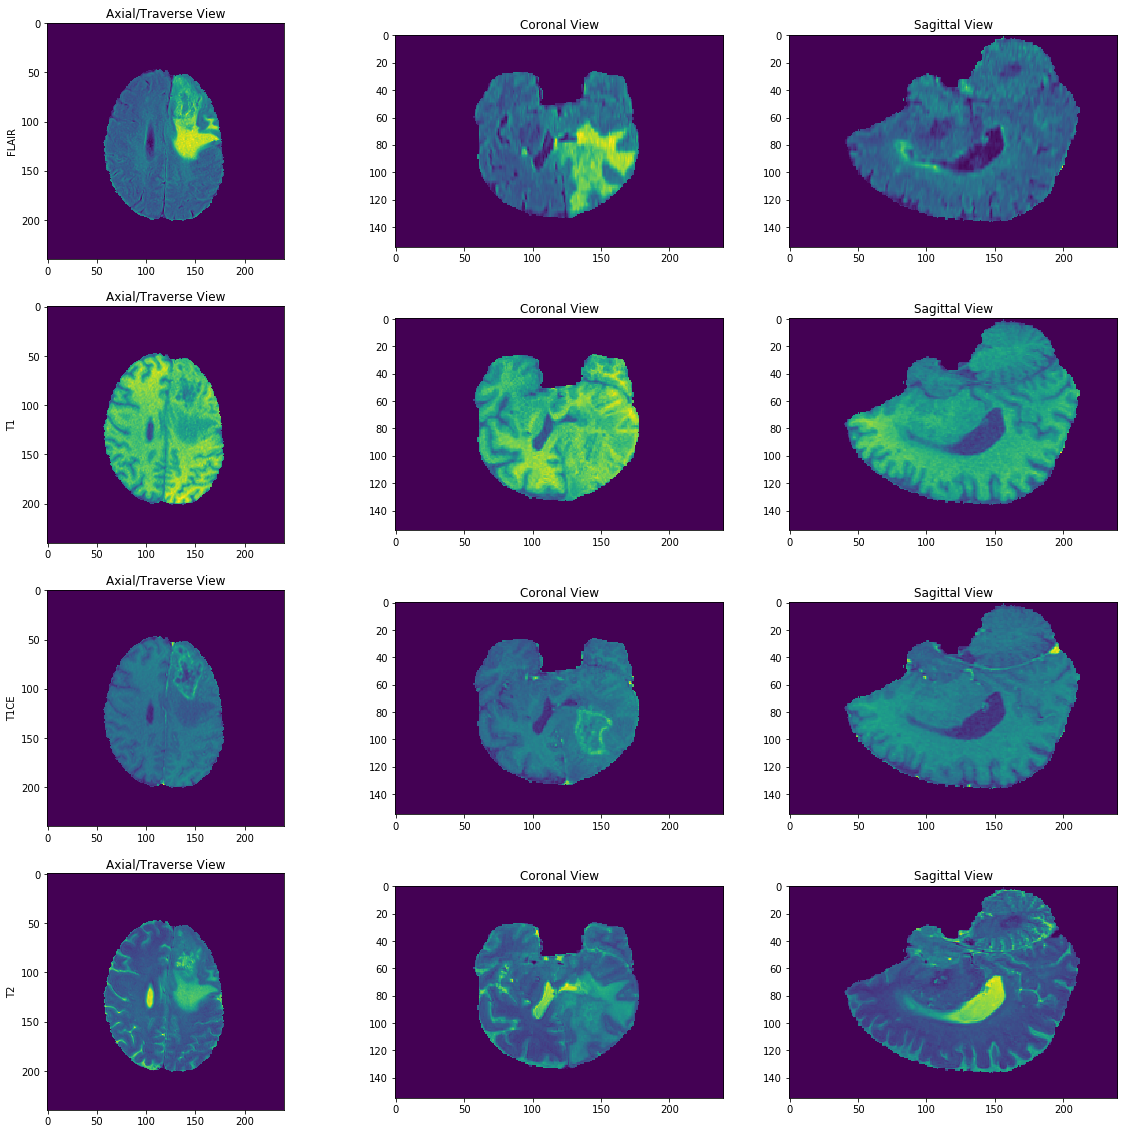

In [59]:
patient_id = 5
k=1
plt.figure(figsize=(20,20))
for i,seq in enumerate(["flair","t1","t1ce","t2"]):
    img = io.imread(full_data[patient_id][seq], plugin='simpleitk')
    for j in range(3):
        if (j==0):
            plt.subplot(4,3,k)
            plt.imshow(img[100,:,:])
            # x-y plane
            plt.title("Axial/Traverse View")
            plt.ylabel(seq.upper())
            k=k+1
        elif (j==1):
            plt.subplot(4,3,k)
            plt.imshow(img[:,100,:])
            plt.title("Coronal View")
            k+=1
        else:
            plt.subplot(4,3,k)
            plt.imshow(img[:,:,100])
            plt.title("Sagittal View")
            k+=1

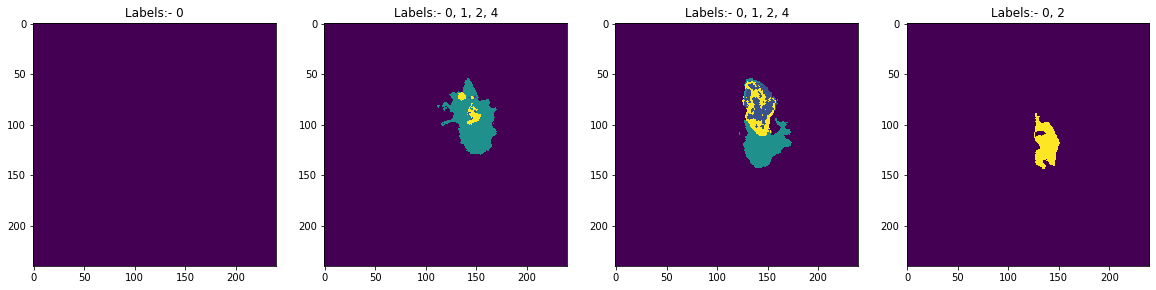

In [84]:
# For the same patient let's also have a look at the target label
img = io.imread(full_data[patient_id]['label'], plugin='simpleitk')
plt.figure(figsize = (20,20))
k = 1
for i in [50, 75,100, 125]:
    plt.subplot(1,4,k)
    plt.imshow(img[i,:,:])
    plt.title("Labels:- " + ", ".join([str(i) for i in np.unique(img[i,:,:])]))
    k+=1

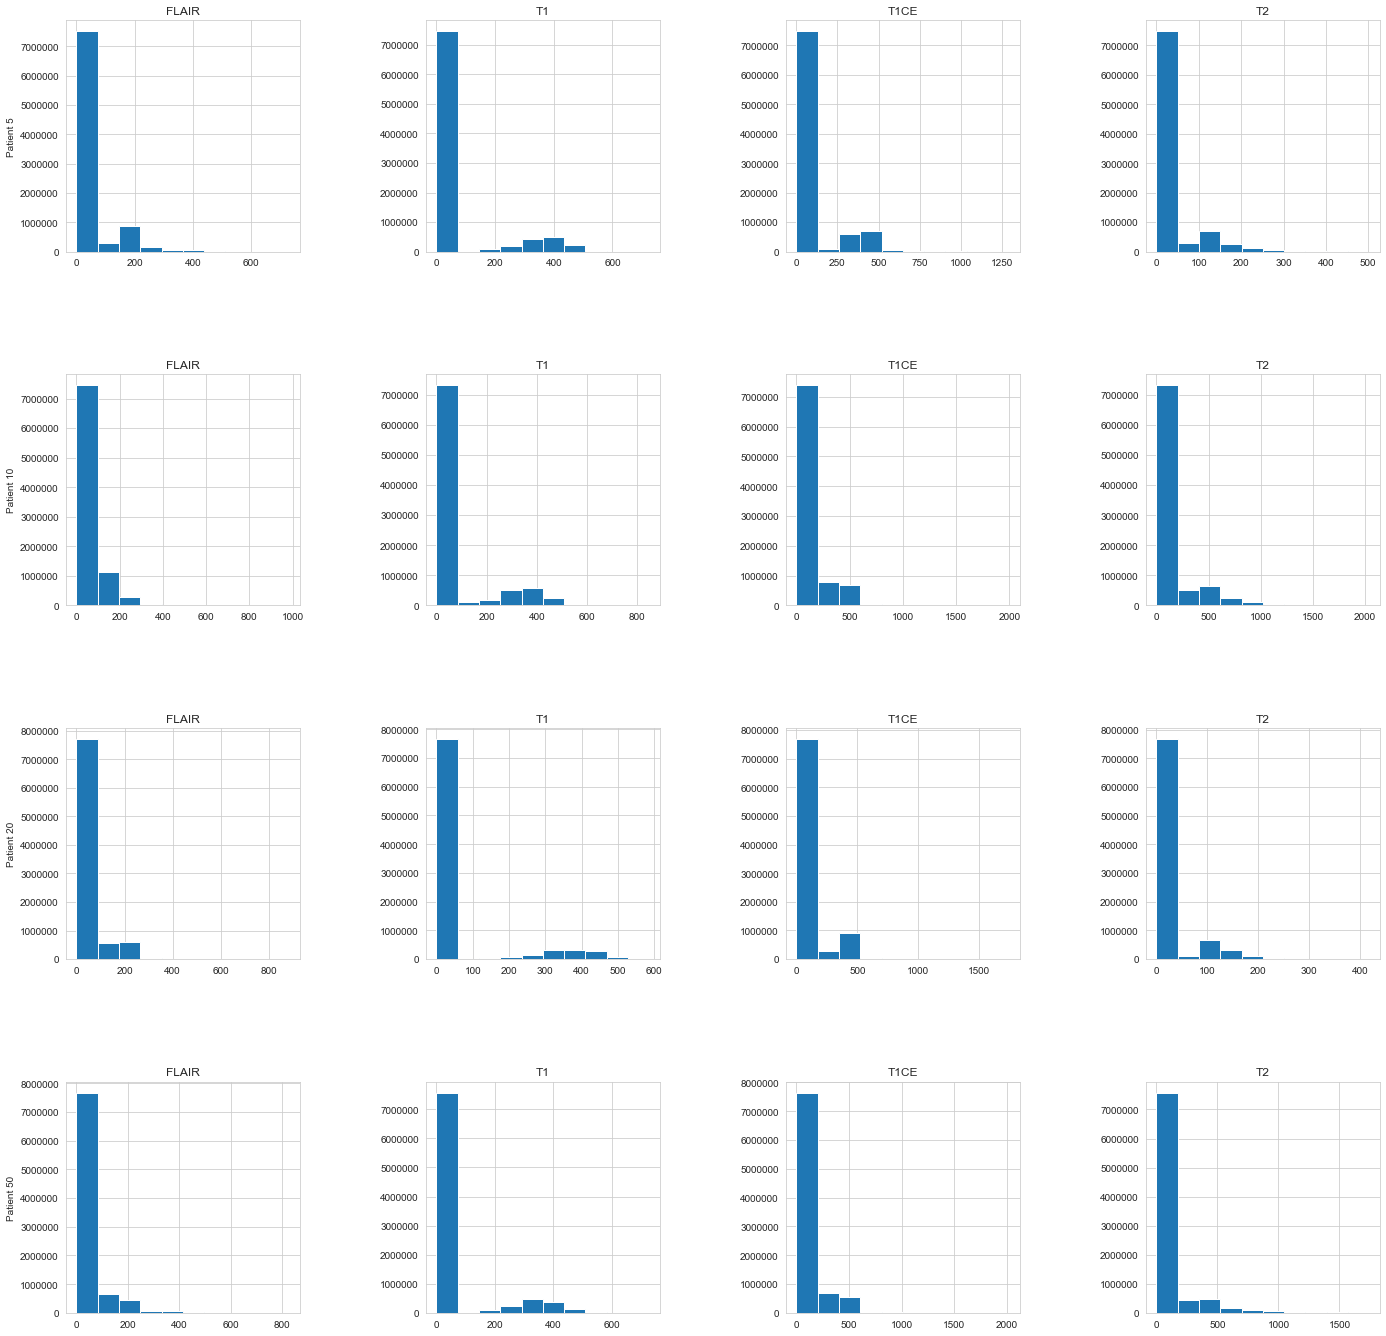

In [156]:
import seaborn as sns
sns.set_style('whitegrid')

fig, axes = plt.subplots(nrows=4, ncols=4)
fig.tight_layout(pad=0.5, w_pad=1, h_pad=0.5)
fig.set_size_inches(20,20)
k=1
for patient_id in [5,10,20,50]:
    for i,seq in enumerate(["flair","t1","t1ce","t2"]):  
        img = io.imread(full_data[patient_id][seq], plugin='simpleitk')
        if (i==0):
            plt.subplot(4,4,k)
            plt.hist(x= img.reshape(-1,1))
            plt.title(seq.upper())
            plt.ylabel("Patient "+str(patient_id))
            k=k+1
        else:
            plt.subplot(4,4,k)
            plt.hist(x= img.reshape(-1,1))
            plt.title(seq.upper())
            k+=1

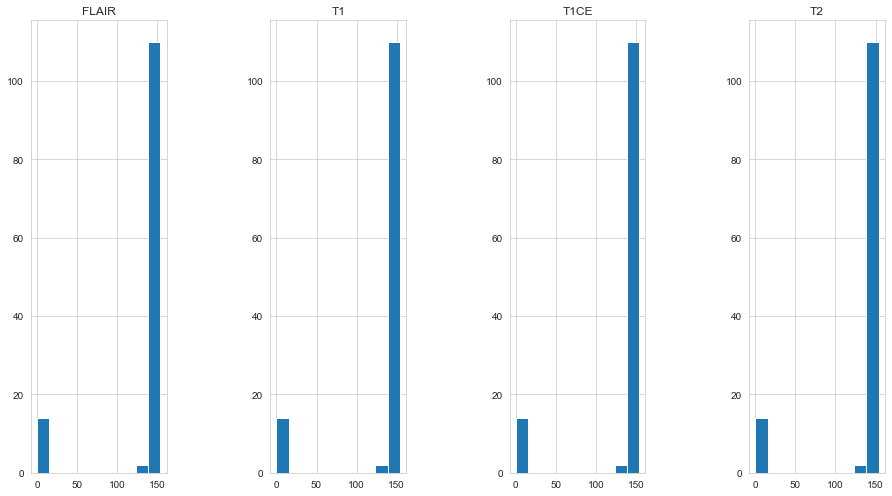

In [225]:
k = 1
from itertools import chain
fig, axes = plt.subplots(nrows=1, ncols=4)
fig.tight_layout(pad=0.5, w_pad=2, h_pad=0.5)
fig.set_size_inches(13,5)
for i,seq in enumerate(["flair","t1","t1ce","t2"]): 
    _indices = []
    for patient_id in range(5,85,10):
        img = io.imread(full_data[patient_id][seq], plugin='simpleitk')
        depth_dimension = img.shape[0]
        _slice = np.array([list(img[i,:,:].reshape(-1,1)) for i in range(depth_dimension)])
        _slice = np.squeeze(_slice,axis = 2).T
        slice_df = pd.DataFrame(_slice)
        # correlation matrix
        _df = slice_df.corr()
        # indices or slice numbers whose correlation is nan
        _indices.append([y for x in np.argwhere(_df.isnull().all(axis=1).values) for y in x])
    plt.subplot(1,4,k)
    plt.hist(x= list(chain.from_iterable(_indices)))
    plt.title(seq.upper())
    k+=1
    

### Bias Field Correction

In [7]:
def correct_bias_field(input_path, output_path):
    inputImage = sitk.ReadImage(input_path)
    maskImage = sitk.OtsuThreshold( inputImage, 
                               0, # Background Value
                               1, # Foreground Value
                               250 # Number of Histograms
                              )

    # Casting to allow real pixel value
    inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    output = corrector.Execute( inputImage, maskImage)
    # Since our original image followed the 16-bit pixel format
    outputCasted = sitk.Cast(output,sitk.sitkVectorUInt16)
    sitk.WriteImage(outputCasted,output_path)

In [8]:
NEW_BASE_DIR = os.path.join(os.path.split(BASE_DIR)[0],
             "PROCESSED_IMAGE","BIAS_CORRECTED")


In [9]:
processed_full_data = {}
for patient_id,v in full_data.items():
    processed_full_data[patient_id] = {}
    for seq,input_path in v.items(): 
        print(f"Started Bias Correction for Patient {patient_id} and Sequence {seq.upper()}")
        folder_name = os.path.split(os.path.split(input_path)[0])[-1]
        file_name  = os.path.split(input_path)[-1]
        output_path = os.path.join(NEW_BASE_DIR,folder_name, file_name)
        
        # Automatically create the directory that doesn't exist
        if not os.path.exists(os.path.join(NEW_BASE_DIR,folder_name)):
            os.makedirs(os.path.join(NEW_BASE_DIR,folder_name))
        
        # Updating the new paths for 4 sequences
        if seq == "label":
            processed_full_data[patient_id].update({seq:input_path})
        else:
            processed_full_data[patient_id].update({seq:output_path})
            correct_bias_field(input_path, output_path)        

Started Bias Correction for Patient 0 and Sequence LABEL
Started Bias Correction for Patient 0 and Sequence FLAIR
Started Bias Correction for Patient 0 and Sequence T1
Started Bias Correction for Patient 0 and Sequence T1CE
Started Bias Correction for Patient 0 and Sequence T2
Started Bias Correction for Patient 1 and Sequence LABEL
Started Bias Correction for Patient 1 and Sequence FLAIR
Started Bias Correction for Patient 1 and Sequence T1
Started Bias Correction for Patient 1 and Sequence T1CE
Started Bias Correction for Patient 1 and Sequence T2
Started Bias Correction for Patient 2 and Sequence LABEL
Started Bias Correction for Patient 2 and Sequence FLAIR
Started Bias Correction for Patient 2 and Sequence T1
Started Bias Correction for Patient 2 and Sequence T1CE
Started Bias Correction for Patient 2 and Sequence T2
Started Bias Correction for Patient 3 and Sequence LABEL
Started Bias Correction for Patient 3 and Sequence FLAIR
Started Bias Correction for Patient 3 and Sequence T

Started Bias Correction for Patient 29 and Sequence T1
Started Bias Correction for Patient 29 and Sequence T1CE
Started Bias Correction for Patient 29 and Sequence T2
Started Bias Correction for Patient 30 and Sequence LABEL
Started Bias Correction for Patient 30 and Sequence FLAIR
Started Bias Correction for Patient 30 and Sequence T1
Started Bias Correction for Patient 30 and Sequence T1CE
Started Bias Correction for Patient 30 and Sequence T2
Started Bias Correction for Patient 31 and Sequence LABEL
Started Bias Correction for Patient 31 and Sequence FLAIR
Started Bias Correction for Patient 31 and Sequence T1
Started Bias Correction for Patient 31 and Sequence T1CE
Started Bias Correction for Patient 31 and Sequence T2
Started Bias Correction for Patient 32 and Sequence LABEL
Started Bias Correction for Patient 32 and Sequence FLAIR
Started Bias Correction for Patient 32 and Sequence T1
Started Bias Correction for Patient 32 and Sequence T1CE
Started Bias Correction for Patient 32 

Started Bias Correction for Patient 58 and Sequence T1
Started Bias Correction for Patient 58 and Sequence T1CE
Started Bias Correction for Patient 58 and Sequence T2
Started Bias Correction for Patient 59 and Sequence LABEL
Started Bias Correction for Patient 59 and Sequence FLAIR
Started Bias Correction for Patient 59 and Sequence T1
Started Bias Correction for Patient 59 and Sequence T1CE
Started Bias Correction for Patient 59 and Sequence T2
Started Bias Correction for Patient 60 and Sequence LABEL
Started Bias Correction for Patient 60 and Sequence FLAIR
Started Bias Correction for Patient 60 and Sequence T1
Started Bias Correction for Patient 60 and Sequence T1CE
Started Bias Correction for Patient 60 and Sequence T2
Started Bias Correction for Patient 61 and Sequence LABEL
Started Bias Correction for Patient 61 and Sequence FLAIR
Started Bias Correction for Patient 61 and Sequence T1
Started Bias Correction for Patient 61 and Sequence T1CE
Started Bias Correction for Patient 61 

Started Bias Correction for Patient 87 and Sequence T1
Started Bias Correction for Patient 87 and Sequence T1CE
Started Bias Correction for Patient 87 and Sequence T2
Started Bias Correction for Patient 88 and Sequence LABEL
Started Bias Correction for Patient 88 and Sequence FLAIR
Started Bias Correction for Patient 88 and Sequence T1
Started Bias Correction for Patient 88 and Sequence T1CE
Started Bias Correction for Patient 88 and Sequence T2
Started Bias Correction for Patient 89 and Sequence LABEL
Started Bias Correction for Patient 89 and Sequence FLAIR
Started Bias Correction for Patient 89 and Sequence T1
Started Bias Correction for Patient 89 and Sequence T1CE
Started Bias Correction for Patient 89 and Sequence T2
Started Bias Correction for Patient 90 and Sequence LABEL
Started Bias Correction for Patient 90 and Sequence FLAIR
Started Bias Correction for Patient 90 and Sequence T1
Started Bias Correction for Patient 90 and Sequence T1CE
Started Bias Correction for Patient 90 

### Slice Correction

In [5]:
import h5py
NEW_BASE_DIR = os.path.join(os.path.split(BASE_DIR)[0],
             "PROCESSED_IMAGE","SLICE_CORRECTED")

# Automatically create the directory that doesn't exist
if not os.path.exists(NEW_BASE_DIR):
    os.makedirs(NEW_BASE_DIR)

In [11]:
for patient_id,v in processed_full_data.items():    
    image_vol_w_seq = {}
    image_mask = []
    for seq,input_path in v.items(): 
        image_volume = io.imread(input_path, plugin='simpleitk')
        slices_to_keep = np.array([_slice for i,_slice in enumerate(image_volume) if i not in (list(range(5))+list(range(140,155)))])
        if seq == "label":
            # To enable one-hot encoding of these categories
            # we make a continous range of classes from 0 to 3
            slices_to_keep[slices_to_keep == 4] = 3
            image_mask = np.copy(slices_to_keep)
        else:
            image_vol_w_seq[seq] = slices_to_keep
        
    final_image = np.stack((image_vol_w_seq['flair'],
                    image_vol_w_seq['t1'],
                    image_vol_w_seq['t1ce'],
                    image_vol_w_seq['t2'])).astype('float')

    
    # Check individual size of mask and train images
    assert image_mask.shape == slices_to_keep.shape
    assert final_image.shape == (4, ) + slices_to_keep.shape

    # Initialize the HDF5 File
    _path = os.path.join(NEW_BASE_DIR, f'{str(patient_id+1).zfill(3)}.h5')
    _hf = h5py.File(_path, 'w')

    # Use create_dataset to give dataset name and provide numpy array
    _hf.create_dataset('X', data = final_image)
    _hf.create_dataset('Y', data = image_mask)

    # Close to write to the disk
    _hf.close()       

In [12]:
# img = io.imread(v['label'], plugin='simpleitk')
# img[img==4] = 3
# x = tf.keras.utils.to_categorical(img, num_classes=4)

In [13]:
# pd.DataFrame([np.sum(x[i][j], axis = 0) for i in range(155) for j in range(240)]).sum()

In [6]:
# import tensorflow as tf
# np.random.seed(23)

In [7]:
# tf.keras.utils.to_categorical([0,1,2,3], num_classes=4)

In [8]:
# tf.keras.utils.to_categorical([[0,1,0,3],[0,0,2,3]], num_classes=4)

### Creating Training Data

In [45]:
def standardize(image):
    """
    Centers the image with mean of zero and sd = 1
    """
    # initialize to array of zeros, with same shape as the image
    standardized_image = np.zeros(image.shape)

    # iterate over sequences
    for c in range(image.shape[0]):
        # iterate over the depth dimension
        for z in range(image.shape[1]):
            image_slice = image[c,z,:,:]

            # subtract the mean from image_slice
            centered = image_slice - np.mean(image_slice)
            
            # divide by the standard deviation (only if it is different from zero)
            if np.std(centered):
                centered_scaled = centered / np.std(centered)
                standardized_image[c, z, :, :] = centered_scaled
            else:
                standardized_image[c, z, :, :] = image_slice

    return standardized_image

In [46]:
NEW_BASE_DIR = os.path.join(os.path.split(BASE_DIR)[0],
             "FINAL_TRAIN_IMAGE")

# Automatically create the directory that doesn't exist
if not os.path.exists(NEW_BASE_DIR):
    os.makedirs(NEW_BASE_DIR)

In [47]:
def get_multiple_patchs(image, label, patient_id, 
                        save_dir,
                        out_dim = (160,160,24),
                        num_classes = 4, 
                        max_tries = 1000,
                        num_patches = 5,
                        background_threshold=0.96):
    """
    Extract random sub-volume from original images.
    
    """
    
    num_channels, orig_z, orig_x, orig_y =  image.shape
    out_x, out_y, out_z = out_dim

    all_patches = []
    tries = 0

    # try until you fail :P
    prev_start = []
    while (tries < max_tries) and (len(all_patches) < num_patches):
#         print(tries)

        # Start from the corner randomly sample a voxel (volume box)
        start_x = np.random.randint(0, orig_x - out_x + 1)
            
        start_y = np.random.randint(0, orig_y - out_y + 1)
            
        start_z = np.random.randint(0, orig_z - out_z + 1)

        # Make sure you are choosing a unique starting point each time
        while (start_x,start_y,start_z) in prev_start:
            start_x = np.random.randint(0, orig_x - out_x + 1)
            start_y = np.random.randint(0, orig_y - out_y + 1)
            start_z = np.random.randint(0, orig_z - out_z + 1)

        # extract relevant area of label
        y = label[start_z: start_z + out_z,
                  start_x: start_x + out_x,
                  start_y: start_y + out_y]

        # One-hot encode the tumor categories to add a 4-th dimension
        y = tf.keras.utils.to_categorical(y,num_classes)

        # compute the background ratio
        bgrd_ratio = np.sum(y[:,:,:,0])/(out_x*out_y*out_z)
        
        # increment tries counter
        tries += 1

        # check if background ratio is less than the maximum background
        # threshold
        if bgrd_ratio < background_threshold:

            # make copy of the sub-volume and take all the channels/seq
            X = np.copy(image[:,
                              start_z: start_z + out_z,
                              start_x: start_x + out_x,
                              start_y: start_y + out_y])

            X_std = standardize(X)

            # we will also make sure that we bring the num class dimension
            # as the first axis
            y = np.moveaxis(y, 3, 0)

            # Exclude the background class as we don't want to predict it
            y = y[1:, :, :, :]

            all_patches.append([X_std, y])
            
            # Initialize the HDF5 File
            _path = os.path.join(save_dir, f'{str(patient_id).zfill(3) + "_" + str(len(all_patches))}.h5')
            _hf = h5py.File(_path, 'w')

            # Use create_dataset to give dataset name and provide numpy array
            _hf.create_dataset('X', data = X_std)
            _hf.create_dataset('Y', data = y)

            # Close to write to the disk
            _hf.close()
            
    return all_patches

In [48]:
processed_path = glob.glob(os.path.join(os.path.join(os.path.split(BASE_DIR)[0],
             "PROCESSED_IMAGE","SLICE_CORRECTED"),"*.h5"))

In [49]:
for _path in processed_path:
    with h5py.File(_path, 'r') as f:
        _image = f.get("X")
        _label = f.get("Y")
        _patient_id = int(os.path.split(_path)[-1].replace(".h5",""))
        x = get_multiple_patchs(_image, _label, _patient_id, NEW_BASE_DIR,
                               out_dim = (180, 160, 24),
                                num_classes = 4, 
                                max_tries = 1000,
                                num_patches = 5,
                                background_threshold=0.96)


### Generator for Train Data

In [6]:
class BatchDataGenerator(tf.keras.utils.Sequence):
    def __init__(self,
                 sample_list,
                 batch_size=1,
                 shuffle=True,
                 dim=(170, 150, 24),
                 num_channels=4,
                 num_classes=3):
    
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dim = dim
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.sample_list = sample_list
        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.sample_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.sample_list) / self.batch_size))

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'

        # Initialization
        X = np.zeros((self.batch_size, self.num_channels, *self.dim),
                     dtype=np.float64)
        y = np.zeros((self.batch_size, self.num_classes, *self.dim),
                     dtype=np.float64)

        # Generate data batch
        for i, ID in enumerate(list_IDs_temp):
            with h5py.File(ID, 'r') as f:
                # to make the data in order (x, y, z)
                X[i] = np.moveaxis(np.array(f.get("X")), 1, 3)
                y[i] = np.moveaxis(np.array(f.get("Y")), 1, 3)
        return X, y

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[
                  index * self.batch_size: (index + 1) * self.batch_size]
        # Find list of IDs
        sample_list_temp = [self.sample_list[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(sample_list_temp)

        return X, y

### Model

In [7]:
from tensorflow.keras import backend as K
K.set_image_data_format("channels_first")

In [8]:
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     laplace_smoothing_factor=0.00001):

    dice_numerator =2 *K.sum(y_pred*y_true,axis) + laplace_smoothing_factor
    dice_denominator = K.sum(y_pred,axis) + K.sum(y_true,axis) + laplace_smoothing_factor
    
    # For multiple classes take the mean across each axis
    dice_coefficient = K.mean(dice_numerator/dice_denominator)

    return dice_coefficient

In [9]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   laplace_smoothing_factor=0.00001):
    """
    Compute mean soft dice loss over all Multiple classes.
    """
    dice_numerator =2 *K.sum(y_pred*y_true,axis) + laplace_smoothing_factor
    dice_denominator = K.sum(y_pred**2,axis) + K.sum(y_true**2,axis) + laplace_smoothing_factor
    dice_loss = 1 - K.mean(dice_numerator / dice_denominator)
    
    return dice_loss

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Activation,
    Conv3D,
    Conv3DTranspose,
    MaxPooling3D,
    UpSampling3D,
    SpatialDropout3D,
    concatenate,
    BatchNormalization
    
)
from tensorflow.keras.optimizers import Adam

In [19]:
def convolution_block(input_layer, n_filters, batch_normalization=False,
                             kernel=(3, 3, 3), activation='selu',
                             padding='same', strides=(1, 1, 1)):
    """
    Creates Convolutional Block
    """
    layer = Conv3D(n_filters, kernel, activation = 'selu', data_format = 'channels_first', 
                   padding = padding, strides = strides)(
        input_layer)
    
    if batch_normalization:
        layer = BatchNormalization(axis=1)(layer)
        
    return layer


def up_convolution(n_filters, pool_size, kernel_size = (2, 2, 2),
                       strides = (2, 2, 2),
                       deconvolution = False):
    if deconvolution:
        return Conv3DTranspose(filters=n_filters, data_format = 'channels_first', 
                               kernel_size=kernel_size, strides=strides)
    else:
        return UpSampling3D(size=pool_size,  data_format = 'channels_first')


def unet_model_3d(loss_function, input_shape=(4, 24, 160, 160),
                  pool_size = 2, n_labels = 3,
                  initial_learning_rate = 0.001,
                  deconvolution=False, depth = 4, n_base_filters = 32, metrics=[],
                  batch_normalization = True):
    
    """
    U-Net 3D Model
    """
    # Input Layer for the Image patch
    inputs = Input(input_shape)
    current_layer = inputs
    levels = list()

    # add levels with max pooling
    for layer_depth in range(depth):
        layer1 = convolution_block(input_layer = current_layer,
                                          n_filters = \
                                   n_base_filters * (2 ** layer_depth),
                                          batch_normalization = \
                                   batch_normalization)
        layer2 = convolution_block(input_layer=layer1,
                                          n_filters = \
                                   n_base_filters * (2 ** layer_depth)* 2,
                                          batch_normalization = \
                                   batch_normalization)
        
        # Do Max-Pooling until reaching the bridge
        if layer_depth < depth - 1:
            current_layer = MaxPooling3D(pool_size = pool_size,  data_format = 'channels_first')(layer2)
            levels.append([layer1, layer2, current_layer])
        else:
            current_layer = layer2
            levels.append([layer1, layer2])

    # add levels with up-convolution or up-sampling
    for layer_depth in range(depth - 2, -1, -1):
        up_convolution_layer = up_convolution(pool_size = pool_size,
                                            deconvolution = deconvolution,
                                            n_filters = \
                                              current_layer.shape[1])(current_layer)
        
        # Concatenate Higher and Lower Dimensions
        concat = concatenate([up_convolution_layer, levels[layer_depth][1]], axis=1)
        
        current_layer = convolution_block(
            n_filters = levels[layer_depth][1].shape[1],
            input_layer = concat, batch_normalization = batch_normalization)
        
        current_layer = convolution_block(
            n_filters=levels[layer_depth][1].shape[1],
            input_layer=current_layer,
            batch_normalization=batch_normalization)

    final_convolution = Conv3D(n_labels, (1, 1, 1),  
                               data_format = 'channels_first',
                              activation = 'sigmoid')(current_layer)
    
    model = Model(inputs = inputs, 
                  outputs = final_convolution)

    if not isinstance(metrics, list):
        metrics = [metrics]

    model.compile(optimizer=Adam(lr = initial_learning_rate), 
                  loss = loss_function,
                  metrics=metrics)
    return model

### Training

In [20]:
import h5py

NEW_BASE_DIR = os.path.join(os.path.split(BASE_DIR)[0],
             "FINAL_TRAIN_IMAGE")

all_patches = glob.glob(os.path.join(NEW_BASE_DIR,"*.h5"))
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(all_patches, test_size=0.33, random_state=42)

In [37]:
model = unet_model_3d(depth = 3,
                      pool_size= 2, 
                      input_shape=(4,180, 160,24), 
                      n_base_filters = 16, 
                      loss_function=soft_dice_loss, metrics=[dice_coefficient])

In [38]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 4, 180, 160, 0                                            
__________________________________________________________________________________________________
conv3d_23 (Conv3D)              (None, 16, 180, 160, 1744        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 16, 180, 160, 64          conv3d_23[0][0]                  
__________________________________________________________________________________________________
conv3d_24 (Conv3D)              (None, 32, 180, 160, 13856       batch_normalization_20[0][0]     
____________________________________________________________________________________________

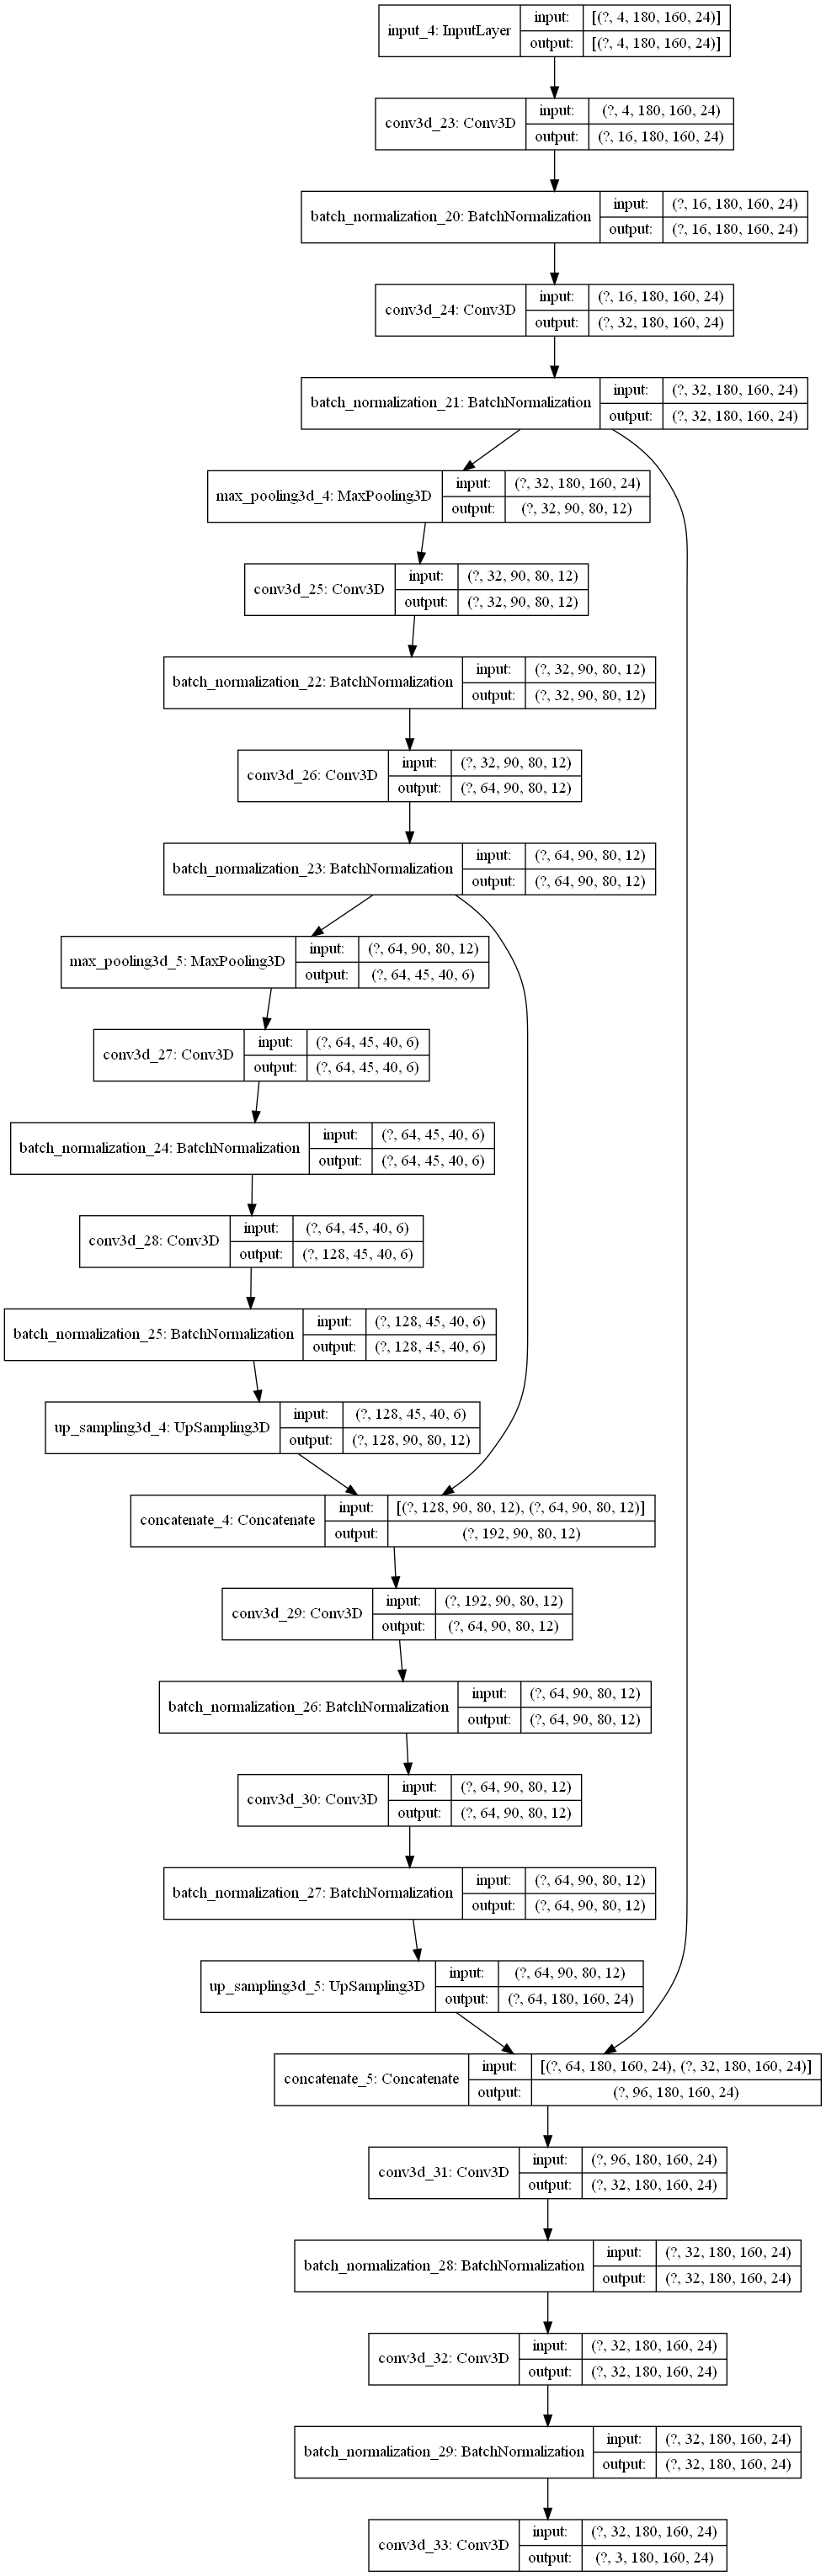

In [39]:
tf.keras.utils.plot_model(model, expand_nested=False, show_shapes=True)

In [44]:
BATCH_SIZE = 2
# Get generators for training and validation sets
train_generator = BatchDataGenerator(train_data, batch_size = BATCH_SIZE, dim = (180, 160, 24))
valid_generator = BatchDataGenerator(val_data, batch_size = BATCH_SIZE, dim = (180, 160, 24))


In [46]:
steps_per_epoch = len(train_data)//BATCH_SIZE
n_epochs=10
validation_steps = len(val_data)//BATCH_SIZE

history = model.fit(train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=n_epochs,
        use_multiprocessing=False,
        validation_data=valid_generator,
        validation_steps=validation_steps)


Epoch 1/10
120/120 [==============================] - 860s 7s/step - loss: 0.3559 - dice_coefficient: 0.4725 - val_loss: 0.4446 - val_dice_coefficient: 0.4008
Epoch 2/10
120/120 [==============================] - 802s 7s/step - loss: 0.3350 - dice_coefficient: 0.5026 - val_loss: 0.3232 - val_dice_coefficient: 0.5164
Epoch 3/10
120/120 [==============================] - 4914s 41s/step - loss: 0.3214 - dice_coefficient: 0.5237 - val_loss: 0.5040 - val_dice_coefficient: 0.3589
Epoch 4/10
120/120 [==============================] - 505s 4s/step - loss: 0.3194 - dice_coefficient: 0.5305 - val_loss: 0.3561 - val_dice_coefficient: 0.4605
Epoch 5/10
120/120 [==============================] - 517s 4s/step - loss: 0.3023 - dice_coefficient: 0.5525 - val_loss: 0.4168 - val_dice_coefficient: 0.4328
Epoch 6/10
120/120 [==============================] - 518s 4s/step - loss: 0.3066 - dice_coefficient: 0.5552 - val_loss: 0.3478 - val_dice_coefficient: 0.5206
Epoch 7/10
120/120 [========================

In [47]:
history.history

{'loss': [0.3558659553527832,
  0.33496442437171936,
  0.3213624060153961,
  0.3193540573120117,
  0.3023258149623871,
  0.30662137269973755,
  0.30536597967147827,
  0.2914295494556427,
  0.30224916338920593,
  0.2864472270011902],
 'dice_coefficient': [0.47254541516304016,
  0.5025898814201355,
  0.5237265229225159,
  0.5305200815200806,
  0.5525329113006592,
  0.5552190542221069,
  0.5596004128456116,
  0.5746464133262634,
  0.5696746110916138,
  0.5864230990409851],
 'val_loss': [0.44459569454193115,
  0.3231589198112488,
  0.5039660334587097,
  0.3560923635959625,
  0.4167533218860626,
  0.34779390692710876,
  0.3900350332260132,
  0.3515271246433258,
  0.3471416234970093,
  0.3278864324092865],
 'val_dice_coefficient': [0.4008313715457916,
  0.5164065957069397,
  0.35886967182159424,
  0.4605149030685425,
  0.43284785747528076,
  0.5206021070480347,
  0.46146127581596375,
  0.5378069281578064,
  0.528603196144104,
  0.5300177931785583]}

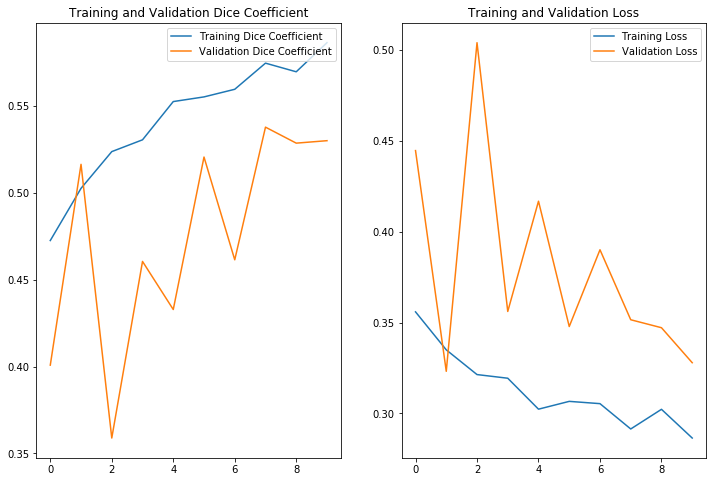

In [50]:
# Plotting libraries and parameters
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
import seaborn as sns

dice_coef = history.history['dice_coefficient']
val_dice_coef = history.history['val_dice_coefficient']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice_coef, label='Training Dice Coefficient')
plt.plot(epochs_range, val_dice_coef, label='Validation Dice Coefficient')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Coefficient')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Cropping and Padding

In [ ]:
def crop_image(image, label):
    # Create a mask with the background pixels
    mask = image == 0

    # Find the brain area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
    
    # Remove the background
    croped_image = image[top_left[0]:bottom_right[0],
                top_left[1]:bottom_right[1]]
    
    cropped_label = label[top_left[0]:bottom_right[0],
                top_left[1]:bottom_right[1]]

    return croped_image, cropped_label
    
def add_pad(image, label, new_height=180, new_width=180):
    height, width = image.shape

    final_image = np.zeros((new_height, new_width))
    final_label = np.zeros((new_height, new_width))

    pad_left = int((new_width - width) / 2)
    pad_top = int((new_height - height) / 2)
    
    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
    final_label[pad_top:pad_top + height, pad_left:pad_left + width] = label
    
    return final_image, final_label

In [88]:
image_volume = io.imread(processed_full_data[0]['flair'], plugin='simpleitk')
image_volume_label = io.imread(processed_full_data[0]['label'], plugin='simpleitk')

In [89]:
idx = 50

Text(0.5, 1.0, 'Padded Label\n\nShape: 180, 180')

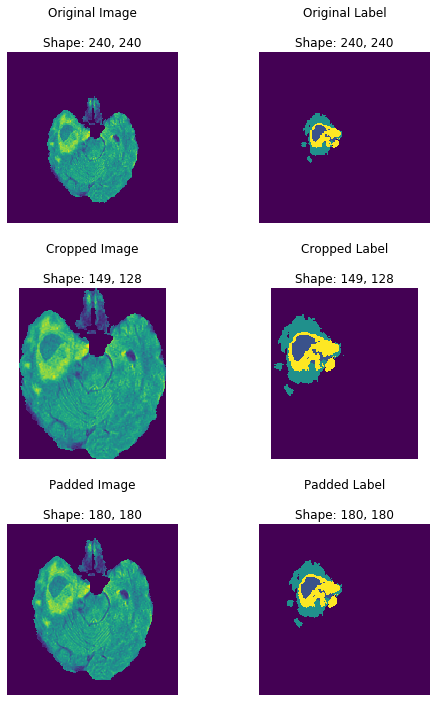

In [90]:
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.tight_layout(pad=0.5, w_pad=1, h_pad=0.5)
fig.set_size_inches(7,10)
plt.subplot(3,2,1)
plt.imshow(image_volume[idx,:,:])
plt.axis('off')
plt.title(f"Original Image\n\nShape: {image_volume.shape[1]}, {image_volume.shape[2]}")
plt.subplot(3,2,2)
plt.imshow(image_volume_label[idx,:,:])
plt.axis('off')
plt.title(f"Original Label\n\nShape: {image_volume_label.shape[1]}, {image_volume_label.shape[2]}")

plt.subplot(3,2,3)
new_image, new_label = crop_image(image_volume[idx,:,:], image_volume_label[idx,:,:])
plt.imshow(new_image)
plt.axis('off')
plt.title(f"Cropped Image\n\nShape: {new_image.shape[0]}, {new_image.shape[1]}")

plt.subplot(3,2,4)
plt.imshow(new_label)
plt.axis('off')
plt.title(f"Cropped Label\n\nShape: {new_label.shape[0]}, {new_label.shape[1]}")

plt.subplot(3,2,5)
new_image, new_label = add_pad(new_image, new_label)
plt.imshow(new_image)
plt.axis('off')
plt.title(f"Padded Image\n\nShape: {new_image.shape[0]}, {new_image.shape[1]}")

plt.subplot(3,2,6)
plt.imshow(new_label)
plt.axis('off')
plt.title(f"Padded Label\n\nShape: {new_label.shape[0]}, {new_label.shape[1]}")

### Dice vs Cross-Entropy

In [54]:
y_true = [[0., 0., 0., 0., 0.], [0., 0., 0., 0., 0.], [0., 1., 1., 0., 0.], [0., 1., 1., 0., 0.], [0., 0., 0., 0., 0.]]
y_pred = [[0., 0., 0., 0., 0.], [0., 0., 0., 0., 0.], [0., 1., 1., 0., 0.], [0., 1., 1., 0., 0.], [0., 0., 0., 0., 0.]]
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true, y_pred).numpy()

-0.0

In [55]:
from tensorflow.keras import backend as K

In [56]:
def dice_coefficient(y_true, y_pred, axis=(0, 1), 
                                  laplace_smoothing_factor=0.00001):  
    
    dice_numerator =2 *K.sum(y_pred*y_true,axis) + laplace_smoothing_factor
    dice_denominator = K.sum(y_pred,axis) + K.sum(y_true,axis) + laplace_smoothing_factor
    dice_coefficient = dice_numerator/dice_denominator
    
    return dice_coefficient

In [61]:
y_true = np.array([[0., 0., 0., 0., 0.], [0., 0., 0., 0., 0.], [0., 1., 1., 0., 0.], [0., 1., 1., 0., 0.], [0., 0., 0., 0., 0.]])
y_pred = np.array([[0., 0., 0., 0., 0.], [0., 0., 0., 0., 0.], [0., 1., 0., 0., 0.], [0., 1., 1., 0., 0.], [0., 0., 0., 0., 0.]])
# choosing a large epsilon to help check for implementation errors
dc = dice_coefficient(y_true, y_pred, axis=(0, 1), laplace_smoothing_factor=1)
print(f"dice coefficient: {dc:.4f}")

dice coefficient: 0.8571


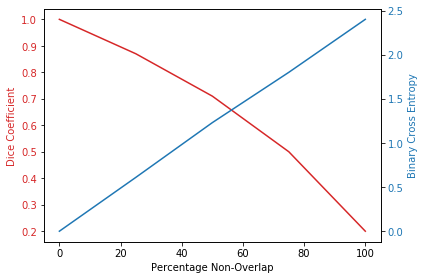

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
t = [100, 75, 50, 25, 0]
data1 = [0.2, 0.5, 0.71, 0.87, 1]
data2 = [2.4, 1.8, 1.23, 0.61, 0]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Percentage Non-Overlap')
ax1.set_ylabel('Dice Coefficient', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Binary Cross Entropy', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()